In [11]:
import numpy as np
import matplotlib.pyplot as plt

import interpolate_matrix as matint
import integrand_interpolation as int

In [40]:
class epsilon:
    def __init__(self, max_linspace, N_LS, N_GL):
        self.linspace_max = max_linspace
        self.N_LS = N_LS
        self.N_GL = N_GL

        x_GL, w_GL = np.polynomial.laguerre.laggauss(N_GL)

        self.eps = np.zeros(N_LS + N_GL)
        self.w = np.zeros_like(self.eps)
        
        self.eps[:N_LS] = np.linspace(0, max_linspace, N_LS)
        self.eps[N_LS:] = x_GL + max_linspace

        self.w[:N_LS] = self.eps[1]
        self.w[0] *= 0.5
        self.w[N_LS-1] *= 0.5
        self.w[N_LS:] = w_GL * np.exp(self.eps[N_LS:]-max_linspace)

class density:
    def __init__(self, max_linspace, N_LS, N_GL, func_e, func_m):
        self.fun_e = func_e
        self.fun_m = func_m

        self.e = epsilon(max_linspace, N_LS, N_GL)
        self.rho = matint.dens_array(self.e.eps, self.fun_e, self.fun_m)

    def fg_exact(self, p_all):
        f = np.zeros(5)
        g = np.zeros(5)
        for i in range(1,5):
            f[i] = self.fun_e(p_all[i-1])
            g[i] = self.fun_m(p_all[i-1])
        return f, g

In [26]:
def matrix_interp_extrap(x, e_epsilon, P_arrays):
    rho_ee = np.zeros(len(e_epsilon.eps))
    rho_mm = np.zeros_like(rho_ee)

    rho_ee[:] = 0.5 * P_arrays[:,0] * (1 + P_arrays[:,3])
    rho_mm[:] = 0.5 * P_arrays[:,0] * (1 - P_arrays[:,3])

    if x > np.max(e_epsilon.eps):
        fe_temp = np.exp(matint.linear_fit(x, e_epsilon.eps[-2:], np.log(rho_ee[-2:])))
        fm_temp = np.exp(matint.linear_fit(x, e_epsilon.eps[-2:], np.log(rho_mm[-2:])))
    else:
        if x < e_epsilon.linspace_max:
            func = matint.interpolate_log_fifth
        else:
            func = matint.interpolate_log_linear
    
        fe_temp = func(x, e_epsilon.eps, rho_ee)
        fm_temp = func(x, e_epsilon.eps, rho_mm)

    return np.array([fe_temp + fm_temp, 0, 0, (fe_temp - fm_temp)/(fe_temp + fm_temp + 1e-100)])

In [41]:
def inner_integral(p1, p2, dens):
    for i in range(len(dens.e.eps)):
        p4 = p1 + p2 - dens.e.eps[i]
        if p4 < 0:
            T1 = 0
            T2 = 0
        else:
            p_array = np.array([p1, p2, dens.e.eps[i], p4])
            f, g = dens.fg_exact(p_array)
            T1, T2 = Fvv(f, g)

SyntaxError: incomplete input (2282356538.py, line 2)

In [42]:
e_og = epsilon(10, 201, 5)
rho_og = density(10, 201, 5, int.f_FD_e, int.f_FD_m)

In [43]:
rho_og.fg_exact([1, 3, 2, 2])

(array([0.        , 0.27091208, 0.04787969, 0.12025686, 0.12025686]),
 array([0.        , 0.26697985, 0.04697615, 0.11815698, 0.11815698]))

In [9]:
e = epsilon(20, 201, 5)

In [47]:
f = np.exp(-e.eps)

In [48]:
np.sum(f * e.w)

1.0008331944757876

In [10]:
ee = np.linspace(0,20,201)
ff = np.exp(-ee)

np.trapz(ff,ee), 1 - np.exp(-10), np.exp(-10)

(1.0008331924146339, 0.9999546000702375, 4.5399929762484854e-05)

In [12]:
rho = matint.dens_array(e_og.eps, int.f_FD_e, int.f_FD_m)

In [27]:
x = np.linspace(0,25,1000)
f = np.zeros_like(x)

for i in range(len(x)):
    g = matrix_interp_extrap(x[i], e_og, rho)
    f[i] = 0.5 * g[0] * (1 + g[3])

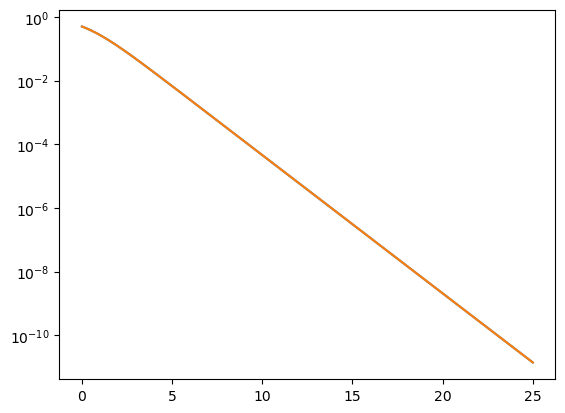

In [21]:
plt.semilogy(x, f)
plt.semilogy(x, int.f_FD_e(x))

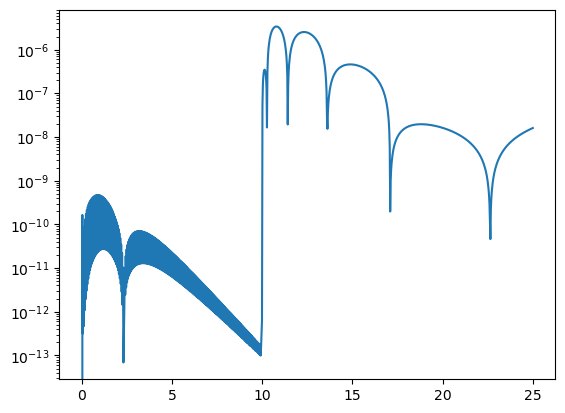

In [23]:
plt.semilogy(x, np.abs(1-f/int.f_FD_e(x)))
